# Earthquake damage classification

## 25 April 2015, Mw7.8 Gorkha Earthquake, Nepal 🇳🇵

## 0: Preliminaries

### Import python libraries 

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import fiona
import folium
import rasterio
import rasterio.mask
import rasterstats as rs
import seaborn as sns
from shapely.geometry import Point
from time import time
import matplotlib.pyplot as plt
%matplotlib inline
starttime = time()

/Users/anirudh/GEM/Code/venvs/horus/lib/python3.9/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  warnings.warn(


### Set the default coordinate reference system

In [2]:
dst_crs = "EPSG:4326"

### Indicate paths to input files

In [3]:
event_name = "M7.8 Gorkha Earthquake, Nepal"
dpm_raw_file = "DPM/ARIA_DPM_ALOS2_f540_v0.5u_climMax07454_T1H1B0U0_dpmRaw.tif"
dpm_clipped_file = "DPM/ARIA_DPM_ALOS2_f540_v0.5u_climMax07454_T1H1B0U0_dpmRaw_ShakeMapMask.tif"
# building_footprints_file = "Buildings/Buildings.geojson"
damage_labels_file = "DamageLabels/Budhanilkantha_Data.csv"
shakemap_url = "https://earthquake.usgs.gov/product/shakemap/us20002926/atlas/1594162031303/download/"
shakemap_json = shakemap_url + "cont_mmi.json" # Contours
shakemap_zip = shakemap_url + "shape.zip" # Polygons

## 1: Demarcate affected area

### Draw an empty map centered on the event

In [4]:
lat = +28.231
lon = +84.731

bound_n = lat + 3
bound_e = lon + 3
bound_s = lat - 3
bound_w = lon - 3

m = folium.Map(
    location=[lat, lon], 
    zoom_start=9,
    tiles='Stamen Terrain')

folium.CircleMarker(
    location=[lat, lon],
    radius=5,
    tooltip="Epicenter",
    popup=event_name,
    color="IndianRed",
    fill_color="LightCoral",
    fill=True
).add_to(m)

m

### Draw ShakeMap contours for MMI ≥ V

In [5]:
style_function = lambda x: {
    'color': x["properties"]["color"],
    'weight': x["properties"]["weight"] if x["properties"]["value"] >= 5 else 0
}
tooltip = folium.features.GeoJsonTooltip(fields=["value"])

folium.GeoJson(
    shakemap_json,
    name="ShakeMap Contours",
    style_function=style_function,
    tooltip=tooltip
).add_to(m)

folium.TileLayer('OpenStreetMap').add_to(m)
folium.LayerControl().add_to(m)

m

### Save the MMI V contour as a vector layer

In [6]:
shakemap_gdf = gpd.read_file(shakemap_json)
shakemapV_gdf = shakemap_gdf[shakemap_gdf.value==5]
shakemapV_gdf.to_file("ShakeMap/MMI_V_Contours.gpkg", driver="GPKG")
shakemapV_gdf.convex_hull.to_file("ShakeMap/MMI_V_Envelope.gpkg", driver="GPKG")

## 2: Load DPM tiles and mask to built areas within MMI≥V

### Read the DPM raster and mask it using the MMI V contour

In [7]:
from rasterio.warp import calculate_default_transform, reproject, Resampling

with fiona.open("ShakeMap/MMI_V_Envelope.gpkg", "r") as shapefile:
    shapes = [feature["geometry"] for feature in shapefile]

with rasterio.open(dpm_raw_file) as src:
    out_image, out_transform = rasterio.mask.mask(src, shapes, crop=True)
    out_meta = src.meta
    
out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})

with rasterio.open(dpm_clipped_file, "w", **out_meta) as dest:
    dest.write(out_image)

### Explore the distribution of the clipped DPM pixel values by plotting a histogram¶

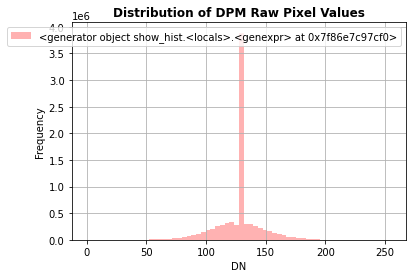

In [8]:
from rasterio.plot import show_hist
dpm_src = rasterio.open(dpm_raw_file)
show_hist(
    dpm_src, bins=64, lw=0.0, stacked=False, alpha=0.3,
    histtype='stepfilled', title="Distribution of DPM Raw Pixel Values")

## 3: Load and plot the building inventory files

### Load the building inventory file for Budhanilkantha 

In [ ]:
# bldgs_gdf = gpd.read_file(building_footprints_file)

### Inspect the building inventory file

In [ ]:
# bldgs_gdf.head()

### Drop unnecessary columns

In [ ]:
# bldgs_gdf.drop(columns=["fid", "ObjectType", "PROMJENA"], inplace=True)

## 4: Join the damage labels to the building inventory

### Load the damage labels ("ground truth" / "test labels")

In [12]:
usecols = ["BuildingID", "AgeOfBuild", "FootprintA", "NumOfStore", "Slope_Grou", "Constr_Typ", "Type_Floor", "Type_Roof", "Build_Posi", "Build_FtPr", "VrtclStrIr", "DMGgrd", "POINT_X", "POINT_Y"]
dmg_labels_df = pd.read_csv(damage_labels_file, usecols=usecols, index_col=0)
dmg_labels_gdf = gpd.GeoDataFrame(
    dmg_labels_df.drop(["POINT_X", "POINT_Y"], axis=1),
    crs=dst_crs,
    geometry=[Point(xy) for xy in zip(dmg_labels_df.POINT_X, dmg_labels_df.POINT_Y)])

### Inspect the damage labels layer contents

In [13]:
dmg_labels_gdf.head()

,AgeOfBuild,FootprintA,NumOfStore,Slope_Grou,Constr_Typ,Type_Floor,Type_Roof,Build_Posi,Build_FtPr,VrtclStrIr,DMGgrd,geometry
BuildingID,,,,,,,,,,,,
XB468001,15,1000,2,Flat,RCFrame,Rigid,Rigid,DetachedBuilding,Rectangular,Regular,3,POINT (85.34770 27.77024)
XB468002,12,1200,1,Flat,RCFrame,Rigid,Rigid,DetachedBuilding,Rectangular,Regular,0,POINT (85.34767 27.77038)
XB468003,8,800,2,Flat,RCFrame,Rigid,Rigid,DetachedBuilding,Rectangular,Regular,2,POINT (85.34785 27.77043)
XB468004,8,1000,1,Flat,Mix,Rigid,Rigid,AdjoiningBuildingOneSide,Square,Regular,1,POINT (85.34791 27.77050)
XB468005,20,1400,2,Flat,RCFrame,Rigid,Rigid,DetachedBuilding,Rectangular,Regular,0,POINT (85.34792 27.77057)


In [14]:
# Clean up field names
dmg_labels_gdf.rename(
    columns={
    "AgeOfBuild": "AGE", 
    "FootprintA": "FOOTPRINT_AREA", 
    "NumOfStore": "NUM_STOREYS", 
    "Slope_Grou": "SLOPE_GROUND", 
    "Constr_Typ": "TYPE_CONSTR", 
    "Type_Floor": "TYPE_FLOOR", 
    "Type_Roof": "TYPE_ROOF", 
    "Build_Posi": "ADJACENCY", 
    "Build_FtPr": "FOOTPRINT_SHAPE", 
    "VrtclStrIr": "IRREGULARITY", 
    "DMGgrd": "DAMAGE_GRADE",
    }, 
    inplace=True)

# Inspect contents of the revised files
dmg_labels_gdf.head()

,AGE,FOOTPRINT_AREA,NUM_STOREYS,SLOPE_GROUND,TYPE_CONSTR,TYPE_FLOOR,TYPE_ROOF,ADJACENCY,FOOTPRINT_SHAPE,IRREGULARITY,DAMAGE_GRADE,geometry
BuildingID,,,,,,,,,,,,
XB468001,15,1000,2,Flat,RCFrame,Rigid,Rigid,DetachedBuilding,Rectangular,Regular,3,POINT (85.34770 27.77024)
XB468002,12,1200,1,Flat,RCFrame,Rigid,Rigid,DetachedBuilding,Rectangular,Regular,0,POINT (85.34767 27.77038)
XB468003,8,800,2,Flat,RCFrame,Rigid,Rigid,DetachedBuilding,Rectangular,Regular,2,POINT (85.34785 27.77043)
XB468004,8,1000,1,Flat,Mix,Rigid,Rigid,AdjoiningBuildingOneSide,Square,Regular,1,POINT (85.34791 27.77050)
XB468005,20,1400,2,Flat,RCFrame,Rigid,Rigid,DetachedBuilding,Rectangular,Regular,0,POINT (85.34792 27.77057)


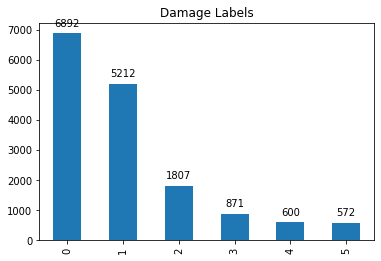

In [15]:
# Inspect the damage grade labels column
ax = (dmg_labels_gdf.DAMAGE_GRADE
      .value_counts()
      .sort_index()
      .plot.bar(
          title="Damage Labels"
      ))
for p in ax.patches:
    ax.annotate(
        p.get_height(), (p.get_x()+p.get_width()/2., p.get_height()), 
        ha='center', va='center', 
        xytext=(0, 10), textcoords='offset points')

### Explanation of damage labels
The damage labels are based on the EMS-98 scale. 
Data source: National Society of Earthquake Technology - Nepal (NSET) and Budhanilkantha Municipality, Kathmandu District

![EMS-98 Damage Grades](https://emergency.copernicus.eu/mapping/sites/default/files/images/DamageAssessement_classification.png)

### Inspect the damage grade labels column after relabeling (if any)

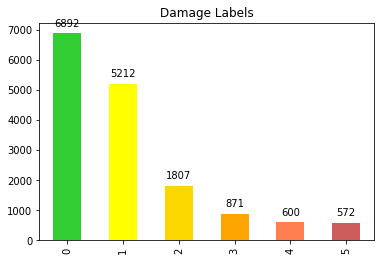

In [16]:
ax = (dmg_labels_gdf.DAMAGE_GRADE
      .value_counts()
      .sort_index()
      .plot.bar(
          title="Damage Labels",
          color=["LimeGreen", "Yellow", "Gold", "Orange", "Coral", "IndianRed"],
      ))
for p in ax.patches:
    ax.annotate(
        p.get_height(), (p.get_x()+p.get_width()/2., p.get_height()), 
        ha='center', va='center', 
        xytext=(0, 10), textcoords='offset points')

#### Note: This is an imbalanced dataset
The number of samples in Damage Grade "0" is roughly two orders of magnitude larger than the number of samples in Damage Grade "3". Most machine learning multiclass classification algorithms assume that all classes have roughly similar numbers of examples.

To circumvent this issue, one potential route is to modify the training set to have similar numbers of examples in each category, for instance by oversampling training examples from the classes with fewer examples.

Another route is to modify the classification algorithm by changing the way learning is performed, preferably biasing more towards those classes that have fewer examples in the training dataset. This is generally called cost-sensitive learning.

In [17]:
# Inspect the coordinate reference system used by the damage database
dmg_labels_gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [18]:
# Reproject the damage dataset to the project coordinate reference system
dmg_labels_gdf = dmg_labels_gdf.to_crs(dst_crs)

### Buffer the points in the damage database to expand each point into a circle of 5m radius

In [19]:
# Buffer each damage label point using a 20 meter buffer zone 
# and replace the point geometry with the new buffered geometry
# The damage database is in the EPSG:3857 CRS, thus the buffer distance is in metres
# Given the coarser resolution of the ALOS DPM, smaller buffer radii
# result in a large number of NaN DPM assignments
dmg_labels_buffer_gdf = dmg_labels_gdf.copy()
dmg_labels_buffer_gdf["geometry"] = dmg_labels_gdf.to_crs("EPSG:3857").buffer(20).to_crs(dst_crs)
dmg_labels_buffer_gdf.head()

,AGE,FOOTPRINT_AREA,NUM_STOREYS,SLOPE_GROUND,TYPE_CONSTR,TYPE_FLOOR,TYPE_ROOF,ADJACENCY,FOOTPRINT_SHAPE,IRREGULARITY,DAMAGE_GRADE,geometry
BuildingID,,,,,,,,,,,,
XB468001,15,1000,2,Flat,RCFrame,Rigid,Rigid,DetachedBuilding,Rectangular,Regular,3,"POLYGON ((85.34788 27.77024, 85.34788 27.77023..."
XB468002,12,1200,1,Flat,RCFrame,Rigid,Rigid,DetachedBuilding,Rectangular,Regular,0,"POLYGON ((85.34785 27.77038, 85.34785 27.77036..."
XB468003,8,800,2,Flat,RCFrame,Rigid,Rigid,DetachedBuilding,Rectangular,Regular,2,"POLYGON ((85.34803 27.77043, 85.34803 27.77041..."
XB468004,8,1000,1,Flat,Mix,Rigid,Rigid,AdjoiningBuildingOneSide,Square,Regular,1,"POLYGON ((85.34809 27.77050, 85.34809 27.77048..."
XB468005,20,1400,2,Flat,RCFrame,Rigid,Rigid,DetachedBuilding,Rectangular,Regular,0,"POLYGON ((85.34810 27.77057, 85.34810 27.77056..."


### Join the damage labels to the building inventory

In [20]:
# Building footprints available from OSM for Budhanilkantha are post-earthquake, 
# so they are missing the collapsed buildings; thus in this case it is better
# to proceed without a building footprint dataset. We treat the buffered damage
# label points as buildings
input_gdf = dmg_labels_buffer_gdf

## 5. Join ShakeMap intensity to building inventory

### Join ShakeMap value to the building inventory

In [21]:
# Build url for the ShakeMap polygons shapefile and perform a spatial join
tic = time()
shakemap_shp = f"zip+{shakemap_zip}!mi.shp"
shakemap_gdf = gpd.read_file(shakemap_shp)
inputs_gdf = gpd.sjoin(input_gdf, shakemap_gdf, how="left", op="within")
print(f"Spatial join completed in {time() - tic:.0f}s")

Spatial join completed in 8s


In [22]:
# Drop unneeded columns and rename the remaining ones
inputs_gdf.drop(columns=["index_right", "AREA", "PERIMETER", "PGAPOL_", "PGAPOL_ID", "GRID_CODE"], inplace=True)
inputs_gdf.rename(columns={"Area": "AREA", "layer": "BLDG_TYPE", "PARAMVALUE": "MMI"}, inplace=True)

In [23]:
# Assign buildings with no shaking intensity to a value of MMI=0
inputs_gdf.fillna(value={"MMI": 0}, inplace=True)

In [24]:
# Create both string and numeric versions of the shaking intensity vector
inputs_strings = inputs_gdf.astype({"MMI": str, "DAMAGE_GRADE":str})
inputs_numeric = inputs_gdf.astype({"MMI": float, "DAMAGE_GRADE":int})

In [25]:
# Inspect the joined dataset
inputs_numeric.head()

,AGE,FOOTPRINT_AREA,NUM_STOREYS,SLOPE_GROUND,TYPE_CONSTR,TYPE_FLOOR,TYPE_ROOF,ADJACENCY,FOOTPRINT_SHAPE,IRREGULARITY,DAMAGE_GRADE,geometry,MMI
BuildingID,,,,,,,,,,,,,
XB468001,15,1000,2,Flat,RCFrame,Rigid,Rigid,DetachedBuilding,Rectangular,Regular,3,"POLYGON ((85.34788 27.77024, 85.34788 27.77023...",7.4
XB468002,12,1200,1,Flat,RCFrame,Rigid,Rigid,DetachedBuilding,Rectangular,Regular,0,"POLYGON ((85.34785 27.77038, 85.34785 27.77036...",7.4
XB468003,8,800,2,Flat,RCFrame,Rigid,Rigid,DetachedBuilding,Rectangular,Regular,2,"POLYGON ((85.34803 27.77043, 85.34803 27.77041...",7.4
XB468004,8,1000,1,Flat,Mix,Rigid,Rigid,AdjoiningBuildingOneSide,Square,Regular,1,"POLYGON ((85.34809 27.77050, 85.34809 27.77048...",7.4
XB468005,20,1400,2,Flat,RCFrame,Rigid,Rigid,DetachedBuilding,Rectangular,Regular,0,"POLYGON ((85.34810 27.77057, 85.34810 27.77056...",7.4


/Users/anirudh/GEM/Code/venvs/horus/lib/python3.9/site-packages/seaborn/relational.py:651: UserWarning: You passed a edgecolor/edgecolors ('w') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  points = ax.scatter(*args, **kws)


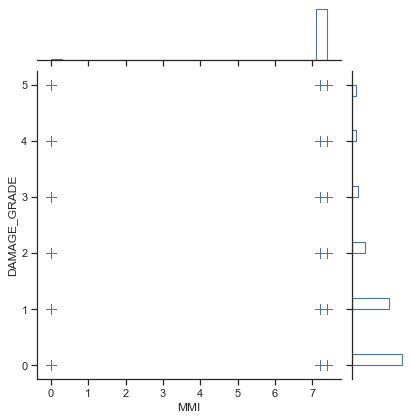

In [26]:
sns.set_theme(style="ticks")
sns.jointplot(
    data=inputs_numeric, 
    x="MMI", y="DAMAGE_GRADE", 
    marker="+", s=100, 
    marginal_kws=dict(bins=25, fill=False),
)

## 6: Join DPM values to the input dataset

### Find the maximum DPM value falling within each buffered building polygon

In [27]:
# This step can take several minutes, depending on the sizes
# of the building inventory + damage database and the DPM raster
tic = time()
with rasterio.open(dpm_clipped_file) as dpm_src:
    dpm_data = dpm_src.read(1, masked=True)
    dpm_meta = dpm_src.profile
    
inputs_list = rs.zonal_stats(
    inputs_numeric,
    dpm_data,
    nodata=-999,
    affine=dpm_meta['transform'],
    geojson_out=True,
    copy_properties=True,
    stats="max")

print(f"Zonal stats query completed in {time() - tic:.0f}s")

# View object type
type(inputs_list)

Zonal stats query completed in 28s


list

### Create dataframe with input variable values and labels

In [28]:
inputs_gdf = gpd.GeoDataFrame.from_features(inputs_list)
inputs_gdf.rename(columns={"max": "DPM_MAX"}, inplace=True)

inputs_gdf.head()

,geometry,ADJACENCY,AGE,DAMAGE_GRADE,FOOTPRINT_AREA,FOOTPRINT_SHAPE,IRREGULARITY,MMI,NUM_STOREYS,SLOPE_GROUND,TYPE_CONSTR,TYPE_FLOOR,TYPE_ROOF,DPM_MAX
0,"POLYGON ((85.34788 27.77024, 85.34788 27.77023...",DetachedBuilding,15,3,1000,Rectangular,Regular,7.4,2,Flat,RCFrame,Rigid,Rigid,131.0
1,"POLYGON ((85.34785 27.77038, 85.34785 27.77036...",DetachedBuilding,12,0,1200,Rectangular,Regular,7.4,1,Flat,RCFrame,Rigid,Rigid,131.0
2,"POLYGON ((85.34803 27.77043, 85.34803 27.77041...",DetachedBuilding,8,2,800,Rectangular,Regular,7.4,2,Flat,RCFrame,Rigid,Rigid,128.0
3,"POLYGON ((85.34809 27.77050, 85.34809 27.77048...",AdjoiningBuildingOneSide,8,1,1000,Square,Regular,7.4,1,Flat,Mix,Rigid,Rigid,128.0
4,"POLYGON ((85.34810 27.77057, 85.34810 27.77056...",DetachedBuilding,20,0,1400,Rectangular,Regular,7.4,2,Flat,RCFrame,Rigid,Rigid,128.0


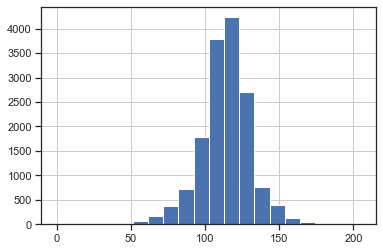

In [29]:
# Plot a histogram of the joined DPM values
# This ignores NaN values, i.e., those buildings for which no DPM value was assigned
dpm_hist = inputs_gdf.DPM_MAX.hist(bins=20)

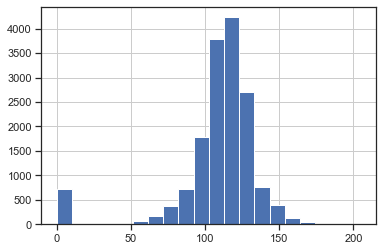

In [30]:
# Assign buildings with no DPM value to a value of DPM=0
inputs_gdf.fillna(value={"DPM_MAX": 0}, inplace=True)
dpm_hist = inputs_gdf.DPM_MAX.hist(bins=20)

## 7: Extract and explore the training features and training labels

### Extract the training labels and values as vectors

In [31]:
train_values = inputs_gdf[["AGE", "FOOTPRINT_AREA", "NUM_STOREYS", "SLOPE_GROUND", "TYPE_CONSTR", "TYPE_FLOOR", "TYPE_ROOF", "ADJACENCY", "FOOTPRINT_SHAPE", "IRREGULARITY", "MMI", "DPM_MAX"]]
train_labels = inputs_gdf[["DAMAGE_GRADE"]]

In [32]:
train_values.dtypes

AGE                  int64
FOOTPRINT_AREA       int64
NUM_STOREYS          int64
SLOPE_GROUND        object
TYPE_CONSTR         object
TYPE_FLOOR          object
TYPE_ROOF           object
ADJACENCY           object
FOOTPRINT_SHAPE     object
IRREGULARITY        object
MMI                float64
DPM_MAX            float64
dtype: object

In [33]:
train_labels.dtypes

DAMAGE_GRADE    int64
dtype: object

### Explore the training data

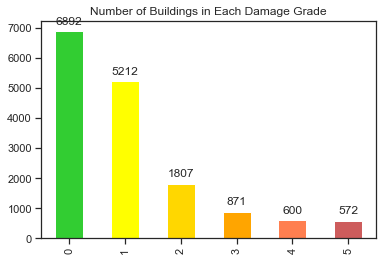

In [34]:
ax = (train_labels.DAMAGE_GRADE
      .value_counts()
      .sort_index()
      .plot.bar(
          title="Number of Buildings in Each Damage Grade",
          color=["LimeGreen", "Yellow", "Gold", "Orange", "Coral", "IndianRed"],
      ))
for p in ax.patches:
    ax.annotate(
        p.get_height(), (p.get_x()+p.get_width()/2., p.get_height()), 
        ha='center', va='center', 
        xytext=(0, 10), textcoords='offset points')

### Select subset of features to use for training

In [35]:
selected_features = ["AGE", "NUM_STOREYS", "SLOPE_GROUND", "TYPE_CONSTR", "TYPE_FLOOR", "TYPE_ROOF", "ADJACENCY", "FOOTPRINT_SHAPE", "IRREGULARITY", "MMI", "DPM_MAX"]
train_values_subset = train_values[selected_features]

### Explore the relationships between the numeric features and labels

/Users/anirudh/GEM/Code/venvs/horus/lib/python3.9/site-packages/seaborn/relational.py:651: UserWarning: You passed a edgecolor/edgecolors ('w') for an unfilled marker ('1').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  points = ax.scatter(*args, **kws)
/Users/anirudh/GEM/Code/venvs/horus/lib/python3.9/site-packages/seaborn/relational.py:651: UserWarning: You passed a edgecolor/edgecolors ('w') for an unfilled marker ('1').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  points = ax.scatter(*args, **kws)
/Users/anirudh/GEM/Code/venvs/horus/lib/python3.9/site-packages/seaborn/relational.py:651: UserWarning: You passed a edgecolor/edgecolors ('w') for an unfilled marker ('1').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  points = ax.scatter(*args, **kws)
/Users/anirudh/GEM/Code/venvs/horus/lib/python3.9/si

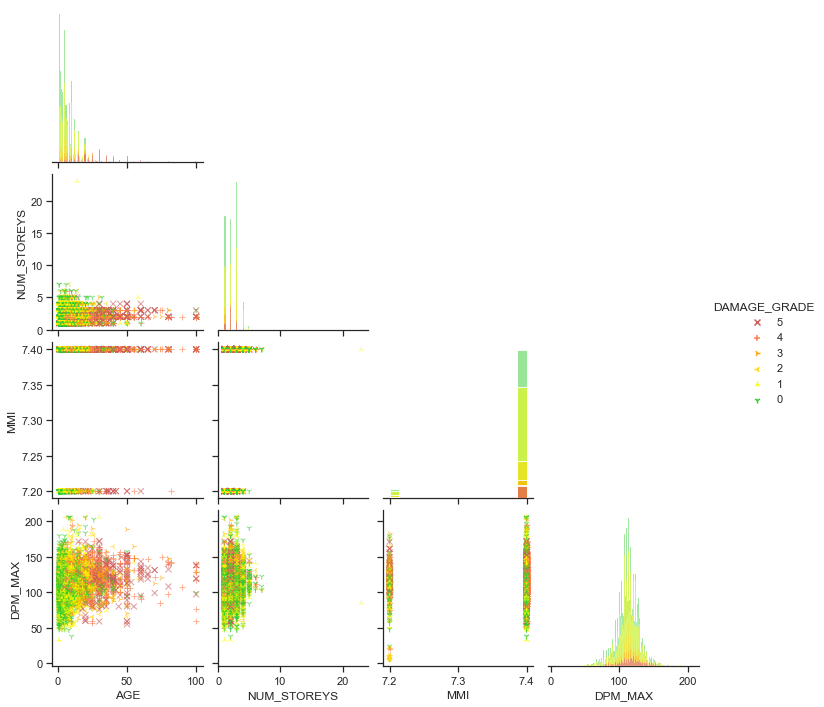

In [36]:
sns.set_theme(style="ticks")
train_values_subset_plot = train_values_subset.replace(0, np.nan)
sns.pairplot(
    train_values_subset_plot.join(train_labels),
    hue="DAMAGE_GRADE",
    hue_order=[5, 4, 3, 2, 1, 0],
    palette={0:"LimeGreen", 1:"Yellow", 2:"Gold", 3:"Orange", 4:"Coral", 5:"IndianRed"},
    markers=["1", "2", "3", "4", "+", "x"],
    kind="scatter",
    diag_kind="hist",
    corner=True,
    plot_kws={'alpha':0.6, 'linewidth':1},
    diag_kws={'fill':True},
    grid_kws={'diag_sharey':False},
)
plt.savefig("Figures/PairPlot_DS5.png")

/Users/anirudh/GEM/Code/venvs/horus/lib/python3.9/site-packages/seaborn/relational.py:651: UserWarning: You passed a edgecolor/edgecolors ('w') for an unfilled marker ('2').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  points = ax.scatter(*args, **kws)
/Users/anirudh/GEM/Code/venvs/horus/lib/python3.9/site-packages/seaborn/relational.py:651: UserWarning: You passed a edgecolor/edgecolors ('w') for an unfilled marker ('2').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  points = ax.scatter(*args, **kws)
/Users/anirudh/GEM/Code/venvs/horus/lib/python3.9/site-packages/seaborn/relational.py:651: UserWarning: You passed a edgecolor/edgecolors ('w') for an unfilled marker ('2').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  points = ax.scatter(*args, **kws)
/Users/anirudh/GEM/Code/venvs/horus/lib/python3.9/si

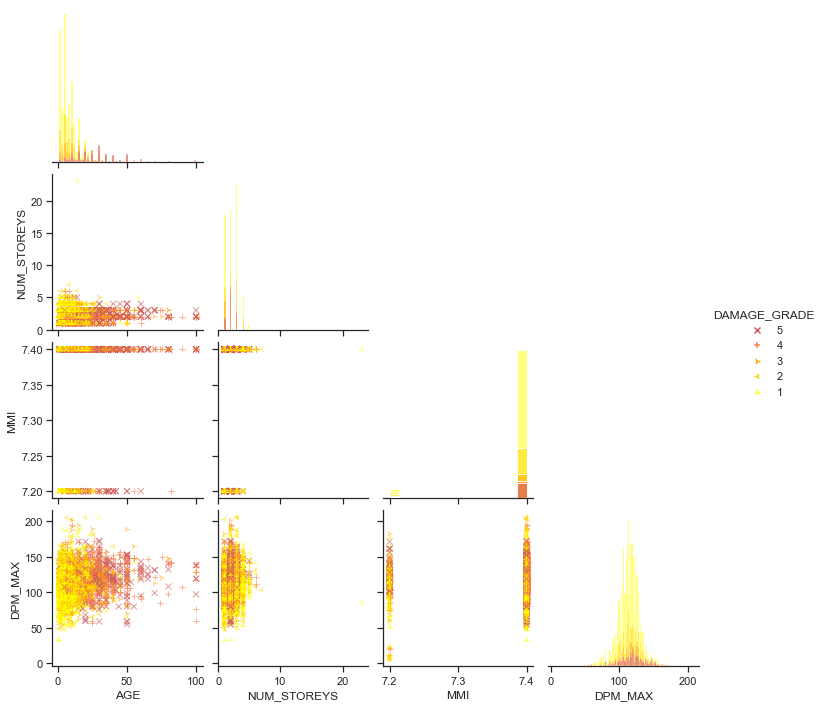

In [37]:
# Ignore Damage Grade 0 for the plots
sns.pairplot(
    train_values_subset_plot.join(train_labels).replace(0, np.nan),
    hue="DAMAGE_GRADE",
    hue_order=[5, 4, 3, 2, 1],
    palette={1:"Yellow", 2:"Gold", 3:"Orange", 4:"Coral", 5:"IndianRed"},
    markers=["2", "3", "4", "+", "x"],
    kind="scatter",
    diag_kind="hist",
    corner=True,
    plot_kws={'alpha':0.6, 'linewidth':1},
    diag_kws={'fill':True},
    grid_kws={'diag_sharey':False},
)
plt.savefig("Figures/PairPlot_DS5.png")

## 8: Build the ML model(s)

### Import modules for the machine learning training component

In [38]:
# for preprocessing the data
from sklearn.preprocessing import StandardScaler

# for unbalanced datasets
from sklearn.utils.class_weight import compute_sample_weight

# for splitting the data into training and test sets
from sklearn.model_selection import train_test_split

# the model(s)
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier

# for combining the preprocess with model training
from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_selector

# for optimizing the hyperparameters of the pipeline
from sklearn.model_selection import GridSearchCV

### Split dataset into training and test subsets

When performing a (supervised) machine learning experiment, it is common to hold out part of the available data as a test set `X_test, y_test`. The best parameters can be determined by grid search techniques.

In [39]:
X_train, X_test, y_train, y_test = train_test_split(train_values_subset, train_labels, train_size=0.70, test_size=0.30, random_state=40)

In [40]:
n_categorical_features = (X_train.dtypes == 'object').sum()
n_numerical_features = ((X_train.dtypes == 'float') | (X_train.dtypes == 'int')).sum()
print(f"Number of training samples: {X_train.shape[0]}")
print(f"Number of training features: {X_train.shape[1]}")
print(f"Number of categorical features: {n_categorical_features}")
print(f"Number of numerical features: {n_numerical_features}")

Number of training samples: 11167
Number of training features: 11
Number of categorical features: 7
Number of numerical features: 4


We will create a HistGradientBoostingRegressor estimator that natively handles categorical features. We let the estimator know which features are categorical.

First, we create an ordinal pipeline that will treat categorical features as if they were ordered quantities, i.e. the categories will be encoded as 0, 1, 2, etc.

In [41]:
ordinal_encoder = make_column_transformer(
    (OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan),
     make_column_selector(dtype_include='object')),
    remainder='passthrough')

In [42]:
# The ordinal encoder will first output the categorical features, and then the
# continuous (passed-through) features
categorical_mask = ([True] * n_categorical_features + [False] * n_numerical_features)

In [43]:
sample_weight = compute_sample_weight(class_weight="balanced", y=y_train)

### Use a Histogram Gradient Boosting Classifier

In [44]:
pipe = make_pipeline(
    ordinal_encoder,
    HistGradientBoostingClassifier(
        random_state=42,
        categorical_features=categorical_mask)
)
pipe

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinalencoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=nan),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f86c0d73370>)])),
                ('histgradientboostingclassifier',
                 HistGradientBoostingClassifier(categorical_features=[True,
                                                                      True,
                                                                      True,
                                                                      True,
                                                                      True,
                                                                      True,
  

### Train a HistGradientBoostingClassifier model with scikit-learn defaults for all parameters

A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting.

In [45]:
tic = time()
gs = pipe
gs.fit(X_train, y_train.values.ravel(), histgradientboostingclassifier__sample_weight=sample_weight)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinalencoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=nan),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f86c0d73370>)])),
                ('histgradientboostingclassifier',
                 HistGradientBoostingClassifier(categorical_features=[True,
                                                                      True,
                                                                      True,
                                                                      True,
                                                                      True,
                                                                      True,
  

In [46]:
print(f"Model fit completed in {time() - tic:.0f}s")

Model fit completed in 2s


### Evaluate the model prediction performance on the _training set_

In [47]:
# Evaluation metrics
# from sklearn.metrics import roc_curve # restricted to the binary classification case
# from sklearn.metrics import plot_precision_recall_curve # restricted to the binary classification case
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import f1_score

#### Compute the F1 score, also known as balanced F-score or F-measure for the _training_ set

The F1 score can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0. The relative contribution of precision and recall to the F1 score are equal. The formula for the F1 score is:

`F1 = 2 * (precision * recall) / (precision + recall)`

In our multi-class case, this is the average of the F1 score of each class with weighting depending on the average parameter.

In [48]:
# Calculate metrics globally by counting the total true positives, 
# false negatives and false positives.
in_sample_preds = gs.predict(train_values_subset)
f1_score(train_labels, in_sample_preds, average='micro')

0.5034474113075091

In [49]:
# Calculate metrics for each label, and find their average weighted 
# the number of true instances for each label. This alters ‘macro’ to 
# account for label imbalance; it can result in an F-score that is not 
# between precision and recall.
f1_score(train_labels, in_sample_preds, average='weighted')

0.5084412820225382

In [50]:
# Calculate metrics for each label, and find their unweighted mean. 
# This does not take label imbalance into account.
f1_score(train_labels, in_sample_preds, average='macro')

0.45768939427083793

#### Print balanced accuracy score for predictions on the _training_ set

The balanced_accuracy_score function computes the balanced accuracy, which avoids inflated performance estimates on imbalanced datasets. It is the macro-average of recall scores per class or, equivalently, raw accuracy where each sample is weighted according to the inverse prevalence of its true class. For balanced datasets, the score is equal to accuracy.

In [51]:
balanced_accuracy_score(train_labels, in_sample_preds)

0.5077697788311792

#### Print classification report for predictions on the _training_ set
The precision is the ratio `tp / (tp + fp)` where `tp` is the number of true positives and `fp` the number of false positives. The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.

The recall is the ratio `tp / (tp + fn)` where `tp` is the number of true positives and `fn` the number of false negatives. The recall is intuitively the ability of the classifier to find all the positive samples.

In [52]:
target_names = ["No Damage", "Slight Damage", "Moderate Damage", "Heavy Damage", "Very Heavy Damage", "Desctruction"]
print(classification_report(train_labels, in_sample_preds, target_names=target_names))

                   precision    recall  f1-score   support

        No Damage       0.65      0.60      0.62      6892
    Slight Damage       0.50      0.42      0.46      5212
  Moderate Damage       0.27      0.34      0.30      1807
     Heavy Damage       0.27      0.38      0.32       871
Very Heavy Damage       0.43      0.62      0.51       600
     Desctruction       0.44      0.69      0.54       572

         accuracy                           0.50     15954
        macro avg       0.43      0.51      0.46     15954
     weighted avg       0.52      0.50      0.51     15954



#### Display the confusion matrix for the predictions on the _training_ set

In [53]:
confusion_matrix(train_labels, in_sample_preds)

array([[4131, 1618,  672,  328,   73,   70],
       [1707, 2196,  793,  344,   98,   74],
       [ 432,  434,  606,  169,   83,   83],
       [  98,   93,  101,  334,  118,  127],
       [  12,   13,   21,   44,  372,  138],
       [  12,    7,   18,   21,  121,  393]])

#### Plot confusion matrix with absolute, non-normalized values

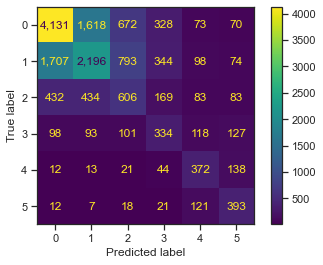

In [54]:
plot_confusion_matrix(
    gs, train_values_subset, train_labels,
    values_format=",",
    cmap="viridis"
)

#### Plot confusion matrix with normalized values

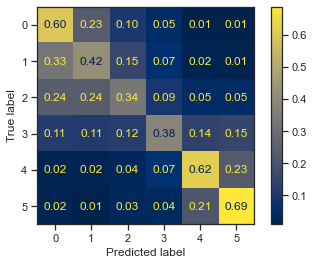

In [55]:
plot_confusion_matrix(
    gs, train_values_subset, train_labels,
    normalize="true",
    values_format=".2f",
    cmap="cividis"
)

### Partial Dependence and Individual Conditional Expectation

In [56]:
from sklearn.inspection import partial_dependence
from sklearn.inspection import plot_partial_dependence

Plot generated in 21s


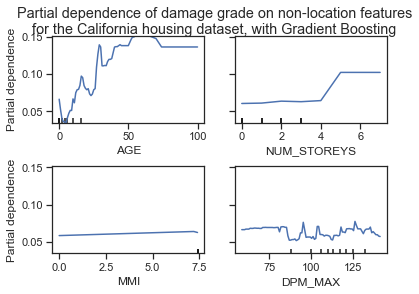

In [57]:
tic = time()
numeric_features = ["AGE", "NUM_STOREYS", "MMI", "DPM_MAX"]
categorical_features = ["TYPE_CONSTR", "TYPE_FLOOR", "TYPE_ROOF", "IRREGULARITY"]
display = plot_partial_dependence(
    gs, X_train, numeric_features, target=5, n_cols=2
)
print(f"Plot generated in {time() - tic:.0f}s")
display.figure_.suptitle(
    'Partial dependence of Damage Grade 5 on building age,\n'
    'number of storeys, shaking intensity (MMI) and DPM value'
)
display.figure_.subplots_adjust(hspace=0.5)

## 9: Make predictions on the test set and evaluate the model performance

### Use the trained ML model to make predictions on the test set

In [58]:
y_pred = gs.predict(X_test)

### Evaluate the model prediction performance on the _test_ set

#### Display the confusion matrix for the predictions on the _test_ set

In [59]:
confusion_matrix(y_test, y_pred)

array([[1199,  500,  210,  100,   22,   15],
       [ 539,  598,  267,  114,   34,   15],
       [ 156,  148,  134,   62,   30,   27],
       [  36,   38,   47,   50,   46,   46],
       [   6,    5,   12,   30,   51,   67],
       [   4,    5,   12,   11,   65,   86]])

#### Plot confusion matrix with absolute, non-normalized values

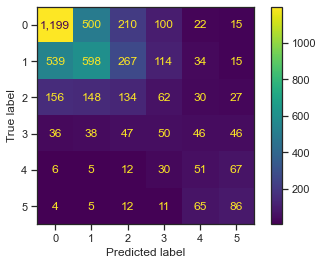

In [60]:
plot_confusion_matrix(
    gs, X_test, y_test,
    values_format=",",
    cmap="viridis"
)

#### Plot confusion matrix with normalized values

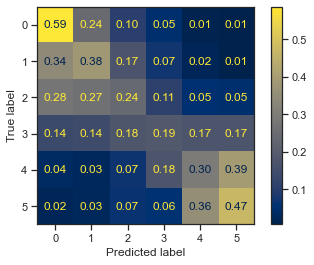

In [61]:
plot_confusion_matrix(
    gs, X_test, y_test,
    normalize="true",
    values_format=".2f",
    cmap="cividis"
)

#### Print classification report for the predictions on the _test_ set

In [62]:
target_names = ["No Damage", "Slight Damage", "Moderate Damage", "Heavy Damage", "Very Heavy Damage", "Desctruction"]
print(classification_report(y_test, y_pred, target_names=target_names))

                   precision    recall  f1-score   support

        No Damage       0.62      0.59      0.60      2046
    Slight Damage       0.46      0.38      0.42      1567
  Moderate Damage       0.20      0.24      0.22       557
     Heavy Damage       0.14      0.19      0.16       263
Very Heavy Damage       0.21      0.30      0.24       171
     Desctruction       0.34      0.47      0.39       183

         accuracy                           0.44      4787
        macro avg       0.33      0.36      0.34      4787
     weighted avg       0.47      0.44      0.45      4787



#### Print balanced accuracy score for the predictions on the _test_ set

In [63]:
balanced_accuracy_score(y_test, y_pred)

0.36108699684067863

## 10: Try binary classification

### Compress the damage grades into 0 and 1

In [64]:
# Assign buildings with no DPM value to a value of DPM=0
inputs_gdf["DAMAGE_GRADE_BINARY"] = inputs_gdf.DAMAGE_GRADE.apply(lambda x: 0 if x<=2 else 1)

### Extract the training features and training labels

In [65]:
train_values = inputs_gdf[["AGE", "FOOTPRINT_AREA", "NUM_STOREYS", "SLOPE_GROUND", "TYPE_CONSTR", "TYPE_FLOOR", "TYPE_ROOF", "ADJACENCY", "FOOTPRINT_SHAPE", "IRREGULARITY", "MMI", "DPM_MAX"]]
train_labels = inputs_gdf[["DAMAGE_GRADE_BINARY"]]

In [66]:
train_values.dtypes

AGE                  int64
FOOTPRINT_AREA       int64
NUM_STOREYS          int64
SLOPE_GROUND        object
TYPE_CONSTR         object
TYPE_FLOOR          object
TYPE_ROOF           object
ADJACENCY           object
FOOTPRINT_SHAPE     object
IRREGULARITY        object
MMI                float64
DPM_MAX            float64
dtype: object

In [67]:
train_labels.dtypes

DAMAGE_GRADE_BINARY    int64
dtype: object

### Explore the training data

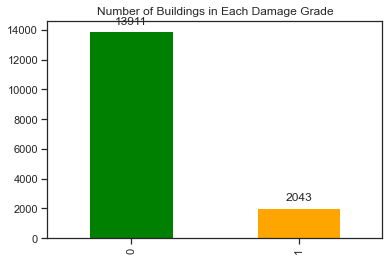

In [68]:
ax = (train_labels.DAMAGE_GRADE_BINARY
      .value_counts()
      .sort_index()
      .plot.bar(
          title="Number of Buildings in Each Damage Grade",
          color=["Green", "Orange"],
      ))
for p in ax.patches:
    ax.annotate(
        p.get_height(), (p.get_x()+p.get_width()/2., p.get_height()), 
        ha='center', va='center', 
        xytext=(0, 10), textcoords='offset points')

### Select subset of features to use for training

In [69]:
selected_features = ["AGE", "NUM_STOREYS", "SLOPE_GROUND", "TYPE_CONSTR", "TYPE_FLOOR", "TYPE_ROOF", "ADJACENCY", "FOOTPRINT_SHAPE", "IRREGULARITY", "MMI", "DPM_MAX"]
train_values_subset = train_values[selected_features]

### Explore the relationships between the numeric features and labels

/Users/anirudh/GEM/Code/venvs/horus/lib/python3.9/site-packages/seaborn/relational.py:651: UserWarning: You passed a edgecolor/edgecolors ('w') for an unfilled marker ('1').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  points = ax.scatter(*args, **kws)
/Users/anirudh/GEM/Code/venvs/horus/lib/python3.9/site-packages/seaborn/relational.py:651: UserWarning: You passed a edgecolor/edgecolors ('w') for an unfilled marker ('1').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  points = ax.scatter(*args, **kws)
/Users/anirudh/GEM/Code/venvs/horus/lib/python3.9/site-packages/seaborn/relational.py:651: UserWarning: You passed a edgecolor/edgecolors ('w') for an unfilled marker ('1').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  points = ax.scatter(*args, **kws)
/Users/anirudh/GEM/Code/venvs/horus/lib/python3.9/si

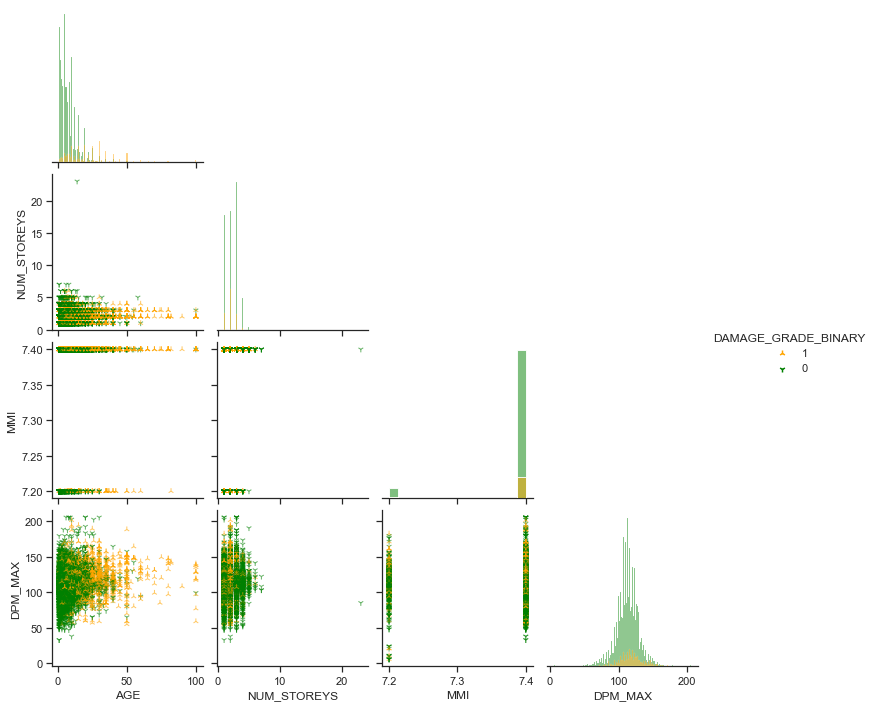

In [70]:
sns.set_theme(style="ticks")
train_values_subset_plot = train_values_subset.replace(0, np.nan)
sns.pairplot(
    train_values_subset_plot.join(train_labels),
    hue="DAMAGE_GRADE_BINARY",
    hue_order=[1, 0],
    palette={0:"Green", 1:"Orange"},
    markers=["1", "2"],
    kind="scatter",
    diag_kind="hist",
    corner=True,
    plot_kws={'alpha':0.6, 'linewidth':1},
    diag_kws={'fill':True},
    grid_kws={'diag_sharey':False},
)

### Split dataset into training and test subsets

When performing a (supervised) machine learning experiment, it is common to hold out part of the available data as a test set `X_test, y_test`. The best parameters can be determined by grid search techniques.

In [71]:
X_train, X_test, y_train, y_test = train_test_split(train_values_subset, train_labels, train_size=0.70, test_size=0.30, random_state=40)

In [72]:
ordinal_encoder = make_column_transformer(
    (OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan),
     make_column_selector(dtype_include='object')),
    remainder='passthrough')

In [73]:
# The ordinal encoder will first output the categorical features, and then the
# continuous (passed-through) features
categorical_mask = ([True] * n_categorical_features + [False] * n_numerical_features)

In [74]:
sample_weight = compute_sample_weight(class_weight="balanced", y=y_train)

### Use a Histogram Gradient Boosting Classifier

In [75]:
pipe = make_pipeline(
    ordinal_encoder,
    HistGradientBoostingClassifier(
        random_state=42,
        categorical_features=categorical_mask)
)
pipe

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinalencoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=nan),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f86e3884b50>)])),
                ('histgradientboostingclassifier',
                 HistGradientBoostingClassifier(categorical_features=[True,
                                                                      True,
                                                                      True,
                                                                      True,
                                                                      True,
                                                                      True,
  

### Train a HistGradientBoostingClassifier model with scikit-learn defaults for all parameters

A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting.

In [76]:
gs_binary = pipe
gs_binary.fit(X_train, y_train.values.ravel(), histgradientboostingclassifier__sample_weight=sample_weight)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinalencoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=nan),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f86e3884b50>)])),
                ('histgradientboostingclassifier',
                 HistGradientBoostingClassifier(categorical_features=[True,
                                                                      True,
                                                                      True,
                                                                      True,
                                                                      True,
                                                                      True,
  

### Evaluate the model prediction performance on the _training set_

In [77]:
in_sample_preds = gs_binary.predict(train_values_subset)

#### Plot confusion matrix with absolute, non-normalized values

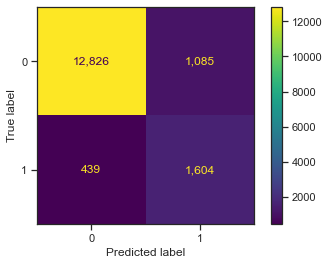

In [78]:
plot_confusion_matrix(
    gs_binary, train_values_subset, train_labels,
    values_format=",",
    cmap="viridis"
)

#### Plot confusion matrix with normalized values

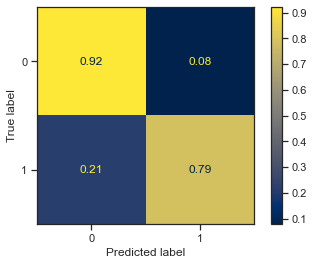

In [79]:
plot_confusion_matrix(
    gs_binary, train_values_subset, train_labels,
    normalize="true",
    values_format=".2f",
    cmap="cividis"
)

### Use the trained model to make predictions on the test set

In [80]:
y_pred = gs_binary.predict(X_test)

#### Display the confusion matrix for the predictions on the test set

In [81]:
confusion_matrix(y_test, y_pred)

array([[3824,  346],
       [ 167,  450]])

#### Plot confusion matrix with absolute, non-normalized values

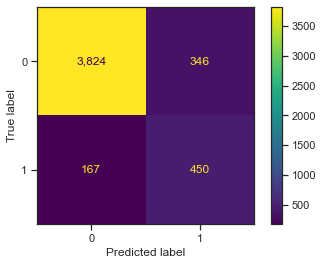

In [82]:
plot_confusion_matrix(
    gs_binary, X_test, y_test,
    values_format=",",
    cmap="viridis"
)

#### Plot confusion matrix with normalized values

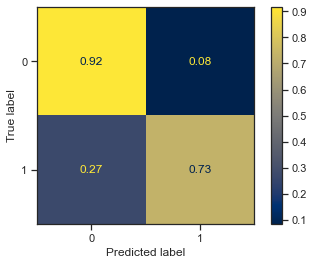

In [83]:
plot_confusion_matrix(
    gs_binary, X_test, y_test,
    normalize="true",
    values_format=".2f",
    cmap="cividis"
)

#### Print classification report for the predictions on the _test_ set

In [84]:
target_names = ["No Damage", "Damage"]
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

   No Damage       0.96      0.92      0.94      4170
      Damage       0.57      0.73      0.64       617

    accuracy                           0.89      4787
   macro avg       0.76      0.82      0.79      4787
weighted avg       0.91      0.89      0.90      4787



#### Print balanced accuracy score for the predictions on the _test_ set

In [85]:
balanced_accuracy_score(y_test, y_pred)

0.8231809366121365